In [77]:
import pandas as pd
import numpy as np
import sys
# PARAMETERS defined by users.
# the input/output path should be pre-defined.
from functions.fun_2R_logic_generator import fun_2R_logic_generator
from functions.lars import lars
from sklearn.linear_model import Lars
np.set_printoptions(threshold=sys.maxsize)
project_name = "example"
path_of_occupancy = './data/occupancy_data.xlsx'
path_of_gene_expression = './data/gene_expression.xlsx'
path_of_output = './output/'
name_of_output = project_name

binding_data = pd.read_excel(path_of_occupancy).values
binding_txt = pd.read_excel(path_of_occupancy).iloc[:,0:2].values
binding_txt = [[text.upper() for text in text_arr] for text_arr in binding_txt]
exp_datafiles = path_of_gene_expression

time_intervals = [1, 1, 2, 2, 4, 4, 2]
KO_sheets = ['TF_exp']

orig_gene_exp_data = {}
orig_gene_txt = {}
orig_TF_exp_data = {}
orig_TF_txt = {}
orig_genes = {}
time_points = {}
sample_hours = {}

for i in range(1):
    orig_gene_exp_data[i], orig_gene_txt[i] = pd.read_excel(exp_datafiles, sheet_name='Gene_exp').values, pd.read_excel(exp_datafiles, sheet_name='Gene_exp').iloc[:,0].values
    orig_gene_exp_data[i] = orig_gene_exp_data[i][:, :]
    orig_TF_txt[i] = {}
    orig_TF_exp_data[i] = {}
    for j in range(len(KO_sheets)):
        some_res_exp, some_res_TF = pd.read_excel(exp_datafiles, sheet_name=KO_sheets[j]).iloc[:,1:].values, pd.read_excel(exp_datafiles, sheet_name=KO_sheets[j]).iloc[:,0].values
        orig_TF_exp_data[i][j], orig_TF_txt[i][j] = some_res_exp, some_res_TF
    orig_genes[i] = orig_gene_txt[i][:]
    time_points[i] = orig_gene_exp_data[i].shape[1]

    sample_hours[i] = time_points[i] * time_intervals[i]


In [78]:
def low_pass_filter(signal, cutoff_frequency):
    """
    Низкочастотный фильтр для преобразования Фурье.
    
    Parameters:
        signal (ndarray): Входной сигнал.
        cutoff_frequency (float): Частота среза для фильтрации.
        
    Returns:
        ndarray: Сглаженный сигнал.
    """
    # Вычисляем преобразование Фурье
    fourier = np.fft.fft(signal)
    
    # Создаем фильтр
    frequencies = np.fft.fftfreq(len(signal))
    mask = (np.abs(frequencies) < cutoff_frequency)
    
    # Применяем фильтр к преобразованию Фурье
    fourier_filtered = fourier * mask
    
    # Выполняем обратное преобразование Фурье
    filtered_signal = np.fft.ifft(fourier_filtered).real
    
    return filtered_signal


def is_cyclic_with_similarity(array1, array2, name='', threshold=0.8):
    correlation = np.corrcoef(array1, array2)[0, 1]
    # if correlation>=threshold:
    #     plt.plot(array1, label='Array 1')
    #     plt.plot(array2, label='Array 2')
    #     plt.title(name)
    #     plt.show()
    return correlation


In [79]:
from sklearn.linear_model import Lars
from sklearn.preprocessing import normalize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


array_3d = np.zeros((6, 6, 6))
def my_function(x=[0,0,0]):
    cyclic_genes = [] 

    cutoff_frequency_TG = 0.3

    TG_exp_data_all = {}
    TG_exp_data_all[0] = []
    gene_exp = {}
    for i, gen_name in enumerate(orig_genes[0]):
        # gene_exp[gen_name] = [(orig_gene_exp_data[0][i][j] + orig_gene_exp_data[0][i][24+j])/2 for j in range(24)]
        correlation = is_cyclic_with_similarity(orig_gene_exp_data[0][i][1:25].astype(float), orig_gene_exp_data[0][i][25:].astype(float), gen_name)
        if correlation > 0.8:
            cyclic_genes.append(gen_name)
            cycled_gene_exp = [orig_gene_exp_data[0][i][1+j] for j in range(48)] #[(orig_gene_exp_data[0][i][1+j] + orig_gene_exp_data[0][i][25+j])/2 for j in range(24)] * 2 #[orig_gene_exp_data[0][i][1+j] for j in range(48)] 
            smoothed = low_pass_filter(cycled_gene_exp, cutoff_frequency_TG)
            # TG_exp_data_all[0].insert(len(cyclic_genes)-1, orig_gene_exp_data[0][i][1:])
            TG_exp_data_all[0].insert(len(cyclic_genes)-1, smoothed)

    TG_exp_data_all[0] = np.array(TG_exp_data_all[0])
    # print(TG_exp_data_all)
    TGs = cyclic_genes

    TFs = orig_TF_txt[0][0][:]

    num_TGs = len(TGs)
    num_TFs = len(TFs)

    cutoff_frequency_TF = 0.3

    TF_exp_data_all = {}
    for i in range(1):  # experiments
        TF_exp_data_all[i] = {}
        for j in range(len(KO_sheets)):
            some = []
            for k in range(len(orig_TF_exp_data[i][j])):
                some.insert(k, [(orig_TF_exp_data[i][j][k][r] + orig_TF_exp_data[i][j][k][24+r])/2 for r in range(24)] * 2)
            TF_exp_data_all[i][j] = some
            

    code = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
    operator_set = ['|', '&', '>']
    delay = 1

    replicates = [1, 1, 1, 2, 3, 3, 1]

    TFs = [tf.upper() for tf in TFs]
    TGs = [tg.upper() for tg in TGs]


    ind_experiment = 0

    # TF_exp_data_all[0][0][0] = low_pass_filter(np.roll(TF_exp_data_all[0][0][0],3).astype(float), cutoff_frequency_TF) #3
    # TF_exp_data_all[0][0][1] = low_pass_filter(np.roll(TF_exp_data_all[0][0][1],3).astype(float), cutoff_frequency_TF) #3
    # TF_exp_data_all[0][0][2] = low_pass_filter(np.roll(TF_exp_data_all[0][0][2],5).astype(float), cutoff_frequency_TF) #5
    # TF_exp_data_all[0][0][3] = low_pass_filter(np.roll(TF_exp_data_all[0][0][3],5).astype(float), cutoff_frequency_TF) #5
    # TF_exp_data_all[0][0][4] = low_pass_filter(np.roll(TF_exp_data_all[0][0][4],0).astype(float), cutoff_frequency_TF) #0
    # TF_exp_data_all[0][0][5] = low_pass_filter(np.roll(TF_exp_data_all[0][0][5],0).astype(float), cutoff_frequency_TF) #0
    # TF_exp_data_all[0][0][6] = low_pass_filter(np.roll(TF_exp_data_all[0][0][6],5).astype(float), cutoff_frequency_TF) #5
    # TF_exp_data_all[0][0][7] = low_pass_filter(np.roll(TF_exp_data_all[0][0][7],0).astype(float), cutoff_frequency_TF) #0
    # TF_exp_data_all[0][0][8] = low_pass_filter(np.roll(TF_exp_data_all[0][0][8],2).astype(float), cutoff_frequency_TF) #2
    # TF_exp_data_all[0][0][9] = low_pass_filter(np.roll(TF_exp_data_all[0][0][9],1).astype(float), cutoff_frequency_TF) #1

    print(num_TFs, num_TGs)


    ind_TFS_res = []


    all_logic_string = {}
    for ind_KO in range(len(KO_sheets)):
    # for ind_KO in range(1):
        TG_gene_data = TG_exp_data_all[ind_experiment]
        TF_exp_data = TF_exp_data_all[ind_experiment][ind_KO]
        num_TG = len(TGs)
        num_TF = len(TFs)

        TF_exp_data /= np.max(np.max(TF_exp_data))
        TF_exp_data_1 = TF_exp_data.reshape(TF_exp_data.shape[0] * TF_exp_data.shape[1], 1)

        D = np.percentile(TF_exp_data_1, [50, 95])
        Gene_expr_median = D[0]
        Gene_expr_max95 = D[1]
        k1 = -np.log(0.5) / Gene_expr_median
        k2 = -np.log(0.05) / Gene_expr_max95
        k = min(k1, k2)

        Gene_TF_score = np.ones((num_TG, num_TF))
        all_score = []

        print('start calculate Gene TF score')

        for TG_i in range(num_TG):
            Target = TGs[TG_i]
            TF_bind_on_Target_i = [Target == bind[1] for bind in binding_txt]

            TF_ind_bind_on_Target = np.where(TF_bind_on_Target_i)[0]

            TF_bind_on_Target = [binding_txt[i][0] for i in TF_ind_bind_on_Target]
            for j in range(len(TF_ind_bind_on_Target)):
                ind = (np.char.upper(TF_bind_on_Target[j]) == TFs)
                ind1 = np.where(ind)[0]
                some = Gene_TF_score[TG_i][ind1] + binding_data[TF_ind_bind_on_Target[j]][2]
                Gene_TF_score[TG_i][ind1] = some

        print('Finish calculate Gene TF score')

        tmp = Gene_TF_score.flatten()
        tmp_i = np.where(tmp > 0)[0]

        Gene_TF_score /= np.std(tmp[tmp_i], ddof=1)

        TF_score_mean = np.sum(np.sum(Gene_TF_score)) / (num_TG * num_TF)

        print('start calculate TF occupancy')
        Gene_TF_binding_strength = Gene_TF_score
        occu_mtx = []
        for TG_i in range(num_TG):
            for j in range(num_TF):
                occupancy = 1 - np.exp(-1 * TF_exp_data[j, :]) #1 - np.exp(-Gene_TF_binding_strength[TG_i, j] * TF_exp_data[j, :])
                occu_mtx.append(occupancy)

        print('Finish calculate TF occupancy')
        print('start calculate the logics')

        X = [None] * num_TG
        mZdif = np.zeros((num_TG, TG_gene_data.shape[1]))

        for t in range(1, TG_gene_data.shape[1]):
            mZdif[:, t] = TG_gene_data[:, t] - TG_gene_data[:, t - delay]
        # print(TG_gene_data.shape[1] - 1, [len(shit) for shit in occu_mtx[:1][ : TG_gene_data.shape[1] - 1]], occu_mtx[:1][0][:TG_gene_data.shape[1] - 1])
        for TG_i in range(num_TG):
            X[TG_i] = occu_mtx[TG_i * num_TF: (TG_i+1) * num_TF]
            for j in range(num_TF):
                for k in range(j + 1, num_TF):
                    X[TG_i] = np.vstack((X[TG_i], occu_mtx[TG_i * num_TF + j][ : TG_gene_data.shape[1]] * occu_mtx[TG_i * num_TF + k][ : TG_gene_data.shape[1]]))

        logic_gate, comp_var, map = fun_2R_logic_generator(num_TF, 1)
        map = np.abs(map)
        lgn = map.shape[0]
        vn = map.shape[1]

        logic_num = num_TF + np.sum((np.arange(num_TF - 1) + 1) * 4)

        p0 = np.zeros((num_TG, logic_num))

        p = np.zeros((num_TG, lgn))

        predicted = [None] * num_TG

        all_p0 = {}
        lars_TG = {}
        yarrTG = {}

        for TG_i in range(num_TG):
        # for TG_i in range(1):
            beta_low = 2
            beta_high = 5   
            y = mZdif[TG_i, 1:]
            xarr = X[TG_i].T[:-2]
            yarr = y[delay:]
            
            yarr -= np.mean(yarr)
            yarrTG[TG_i] = yarr
            n, _ = xarr.shape
            xarr -= np.ones((n, 1)) * np.mean(xarr, axis=0)

            xarr_std = np.sqrt(np.sum(xarr**2, axis=0))

            for j in range(xarr.shape[1]):
                if xarr_std[j] == 0:
                    xarr[:, j] = xarr[:, j]
                else:
                    xarr[:, j] = xarr[:, j] / xarr_std[j]

            lars = Lars(n_nonzero_coefs=beta_high).fit(xarr, yarr) #
            lars_TG[TG_i] = lars
            # print(lars.coef_)
            # print(lars.positive)
            beta = lars.coef_path_


            beta = beta.T
            if beta_high > beta.shape[0]:
                beta_high = beta.shape[0] - 1
            # print("BETA" ,beta)
            # print("SBETA" ,beta[beta_high])



            if np.sum(np.sum(xarr_std)) == 0:
                beta = np.zeros((beta.shape[0], beta.shape[1]))
                p0[TG_i, :logic_num] = np.zeros(logic_num)
            else:
                for row in range(beta_low, beta_high):
                    if np.sum(np.isnan(beta[row])) >= 1 or sum(beta[row])==0:
                        continue

                    sbeta = beta[row]

                    sbeta_std = np.std(sbeta[np.nonzero(sbeta)], ddof=1)
                    if np.sum(np.abs(sbeta)) == 0:
                        sigm_sbeta = sbeta
                    elif sbeta_std == 0:
                        sigm_sbeta = sbeta / np.max(np.abs(sbeta))
                    else:
                        sigm_sbeta = (1 - np.exp(-np.abs(sbeta / sbeta_std))) / (1 + np.exp(-np.abs(sbeta / sbeta_std)))
                    # print("SBETA", sbeta)
                    # print(sbeta[np.nonzero(sbeta)])
                    # print("SBETA_STD", sbeta_std)
                    thresh = 0.9
                    p_elmt = np.zeros((lgn, vn))

                    for lg in range(lgn):
                        for v in range(vn):
                            if map[lg, v] == 0:
                                p_elmt[lg, v] = 1 - np.abs(sigm_sbeta[v])
                            else:
                                p_elmt[lg, v] = np.abs(sigm_sbeta[v])

                    for lg in range(lgn):
                        p[TG_i, lg] = 1
                        features = np.sum(map[lg, :])
                        for v in range(vn):
                            if p_elmt[lg, v] >= thresh:
                                p[TG_i, lg] *= p_elmt[lg, v]
                            else:
                                p[TG_i, lg] *= np.sqrt(features) / (np.sqrt(features) + 1)

                    if np.sum(p[TG_i, :]) == 0:
                        pass
                    else:
                        p1 = p[TG_i, :] / np.sum(p[TG_i, :])

                    _, b = np.max(p1), np.argmax(p1)

                    p0[TG_i, :] += p1

        p0max = np.max(p0, axis=1)

        for TG_i in range(num_TG):
            if p0max[TG_i] == 0:
                pass
            else:
                p0[TG_i, :] = p0[TG_i, :] / p0max[TG_i]

        all_p = np.reshape(p0, (1, p0.shape[0] * p0.shape[1]))
        sort_ind = np.argsort(all_p, axis=None)[::-1]
        sort_p = np.sort(all_p, axis=None)[::-1]

        for TG_i in range(num_TG):
            target_gene = TG_i

            cutting_thresh = 1

            logic_ind = np.where(p0[TG_i, :] >= cutting_thresh)[0]

            all_logic_string[TG_i] = []
            for j in range(len(logic_ind)):
                logic_code = logic_gate[logic_ind[j]]

                if j > 0:
                    all_logic_string[TG_i].append('.OR.')

                if len(logic_code) == 1:
                    regulator_code = logic_code
                    ib = code.index(regulator_code)
                    all_logic_string[TG_i].append('(' + str(TFs[ib]) + ')')
                    some_sum = ib
                    TFs_dynamics = X[TG_i][ib, :]
                else:
                    regulator1_code = logic_code[0]
                    regulator2_code = logic_code[2]
                    operator_code = logic_code[1]

                    ib1 = code.index(regulator1_code)
                    ib2 = code.index(regulator2_code)
                    all_logic_string[TG_i].append('(' + str(TFs[ib1]) + '.' + operator_code + '.' + str(TFs[ib2]) + ')')
                    if ib1 > ib2:
                        ib1, ib2 = ib2, ib1
                    some_sum = 9 + sum(i for i in range(num_TFs - ib1,num_TFs)) + ib2 - ib1
                    TFs_dynamics = X[TG_i][some_sum]
                predicted = lars_TG[TG_i].predict(X[TG_i].T[:-2])
                predicted = (predicted-min(predicted)) / (max(predicted)-min(predicted))
                # TFs_dynamics = (TFs_dynamics-min(TFs_dynamics)) / (max(TFs_dynamics)-min(TFs_dynamics))
                # TG_gene_data[TG_i] = np.array((TG_gene_data[TG_i]-min(TG_gene_data[TG_i])) / (max(TG_gene_data[TG_i])-min(TG_gene_data[TG_i])))
                yarrTG[TG_i] = np.array((yarrTG[TG_i]-min(yarrTG[TG_i])) / (max(yarrTG[TG_i])-min(yarrTG[TG_i])))
                # if TGs[TG_i] in ["PEPD", "STAG1", "PARP1","KRTCAP2", "RTP4", "KRAS", "HSPBP1"]:

                # plt.plot(TFs_dynamics/np.linalg.norm(TFs_dynamics), "b")
                # plt.plot(TG_gene_data[TG_i]/np.linalg.norm(TG_gene_data[TG_i]), "r")

                plt.plot(predicted/np.linalg.norm(predicted), "orange") 

                # corr_max = 0
                # for i in range(55):
                #     TFs_dynamics = X[TG_i][i]
                #     TFs_dynamics = (TFs_dynamics-min(TFs_dynamics)) / (max(TFs_dynamics)-min(TFs_dynamics)) 
                correlation = np.corrcoef(predicted.astype(float), yarrTG[TG_i].astype(float))[0, 1]
                #     if correlation > corr_max:
                #         TFs_dynamics_max = TFs_dynamics
                #         corr_max = abs(correlation)
                #         max_idx = i
                # plt.plot(TFs_dynamics_max/np.linalg.norm(TFs_dynamics_max))
                plt.plot(yarrTG[TG_i]/np.linalg.norm(yarrTG[TG_i]), "g")
                # ind_TFS_res.append(max_idx)
                ind_TFS_res.append(correlation)
                plt.title(TGs[TG_i] + " " + str(correlation))
                plt.show()


            print(TGs[TG_i], " ",''.join(all_logic_string[TG_i]), "\n")
        # print(sum(ind_TFS_res) / len(ind_TFS_res))
        print('Finish calculate logics WITH ARGS: ', x)
        all_p0[ind_experiment] = {}
        all_p0[ind_experiment][ind_KO] = p0
        if not ind_TFS_res:
            ind_TFS_res = [-1]
        # print(''.join(all_logic_string), "\n")
    array_3d[x[0],x[1],x[2]] = sum(ind_TFS_res) / len(ind_TFS_res)
    return -1 * sum(ind_TFS_res) / len(ind_TFS_res)

10 20
start calculate Gene TF score
Finish calculate Gene TF score
start calculate TF occupancy
Finish calculate TF occupancy
start calculate the logics


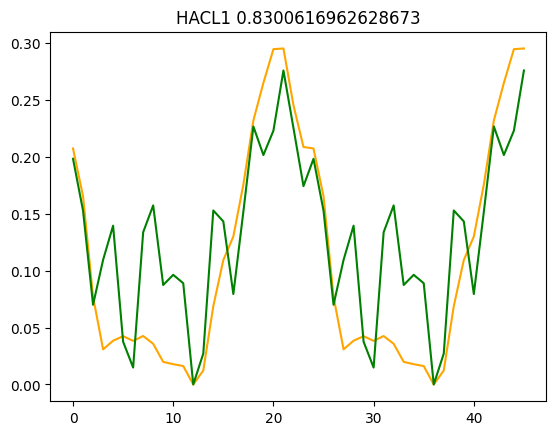

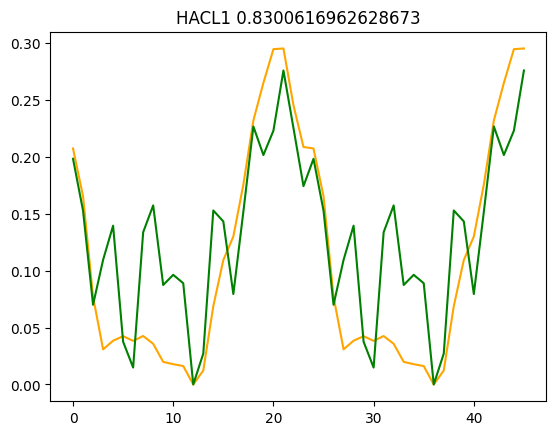

HACL1   (ARNTL.&.PER1).OR.(PER2.&.POLR2A) 



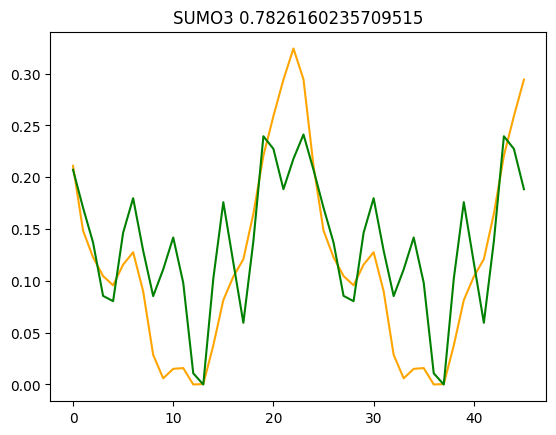

SUMO3   (CREBBP.&.EP300) 



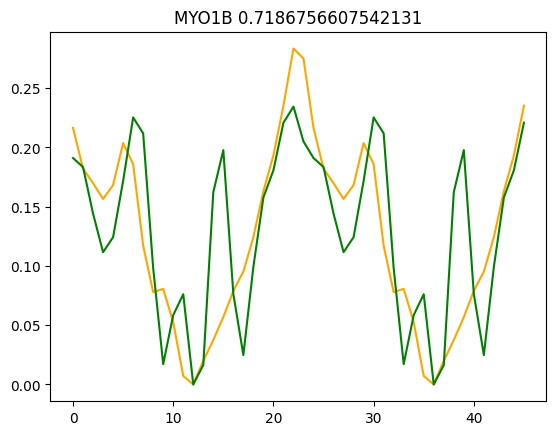

MYO1B   (NPAS2.&.CREBBP) 



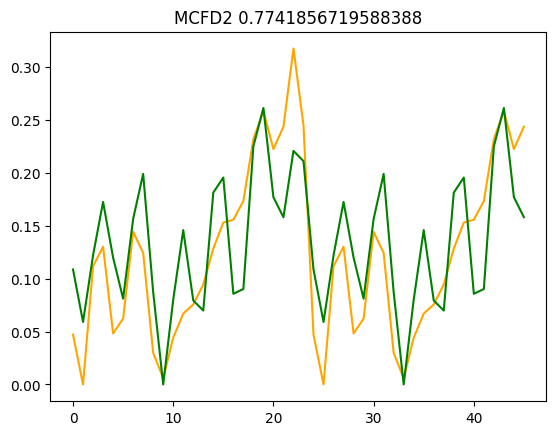

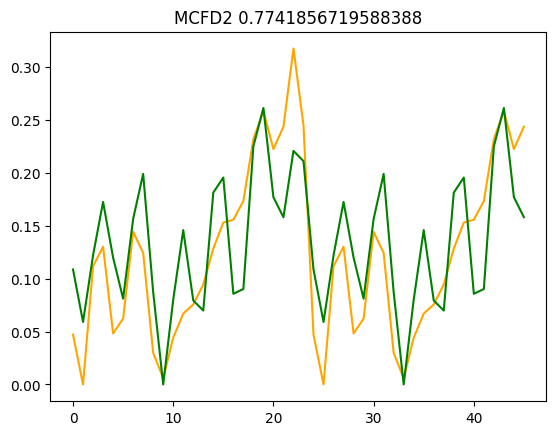

MCFD2   (CLOCK.&.CREBBP).OR.(CREBBP.&.POLR2A) 



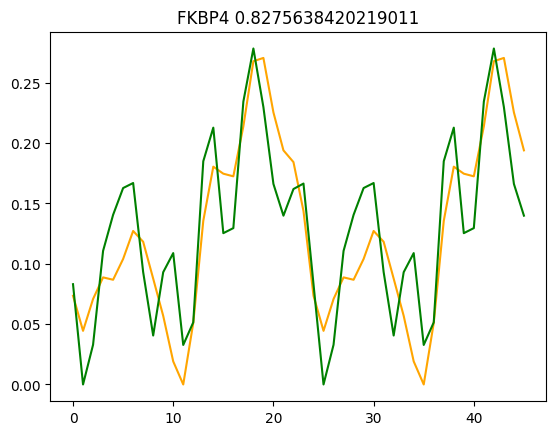

FKBP4   (CRY2.>.PER1) 



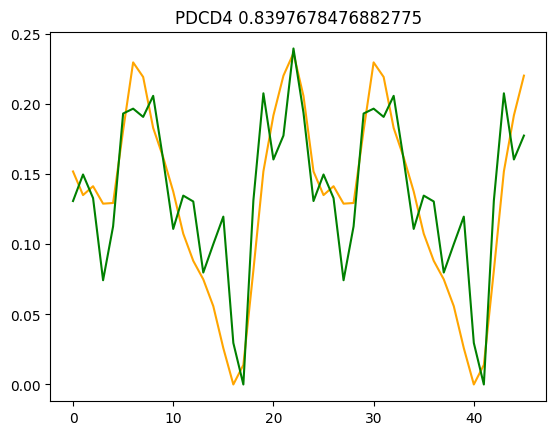

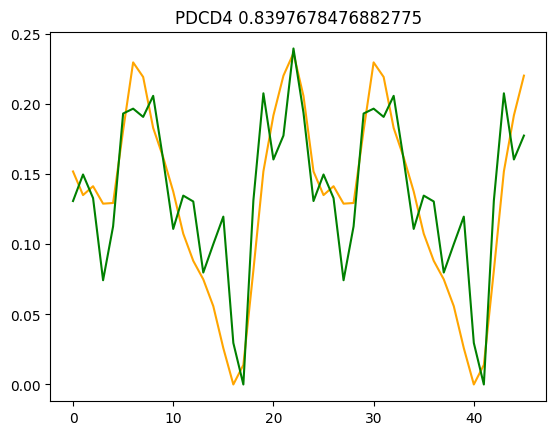

PDCD4   (CRY1.&.PER2).OR.(PER1.&.CREBBP) 



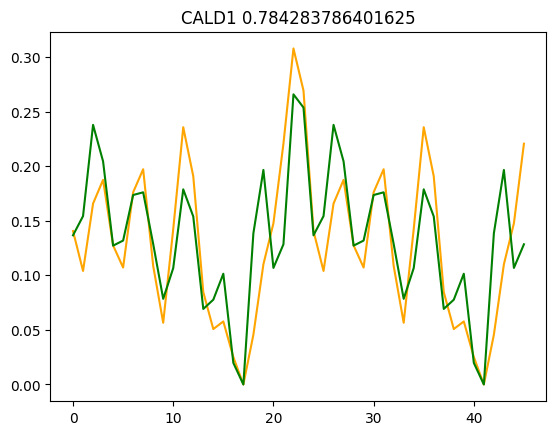

CALD1   (CRY2.&.CREBBP) 



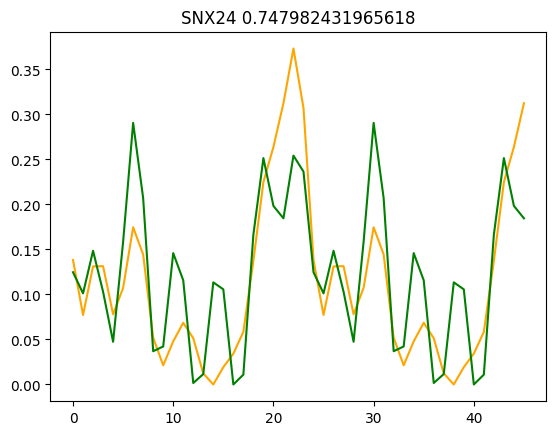

SNX24   (CREBBP.&.EP300) 



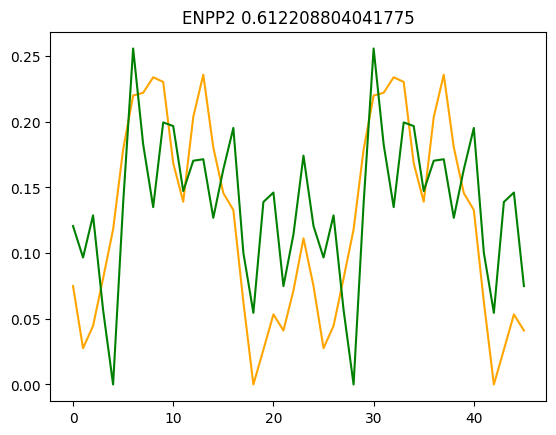

ENPP2   (CLOCK.&.CRY2) 



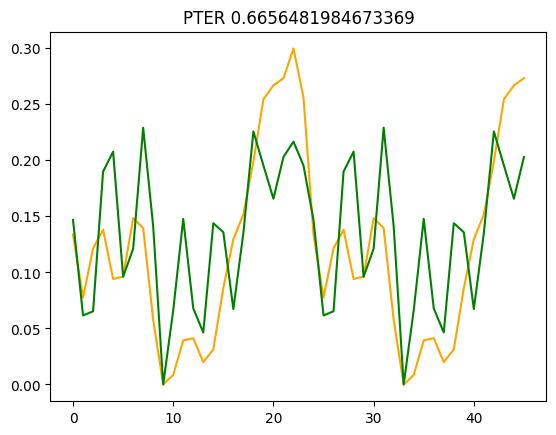

PTER   (CREBBP.>.NPAS2) 



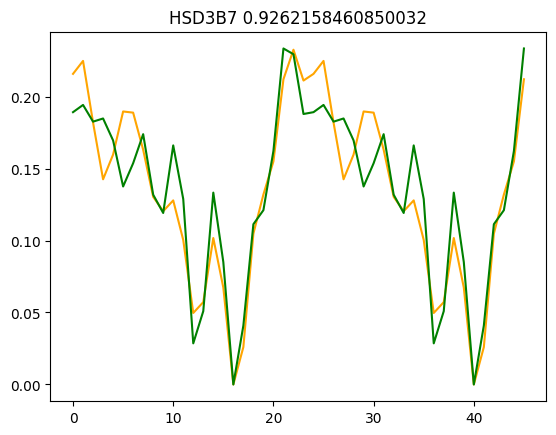

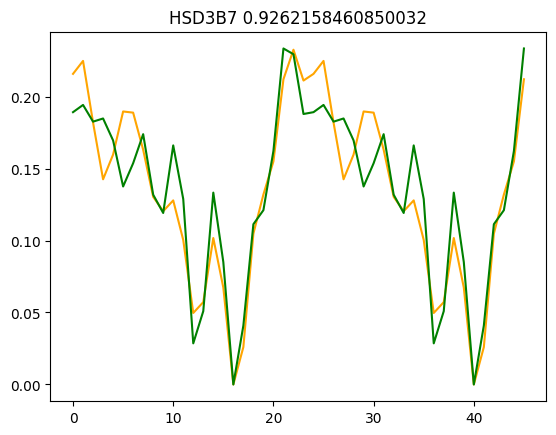

HSD3B7   (EP300).OR.(PER1.&.CREBBP) 



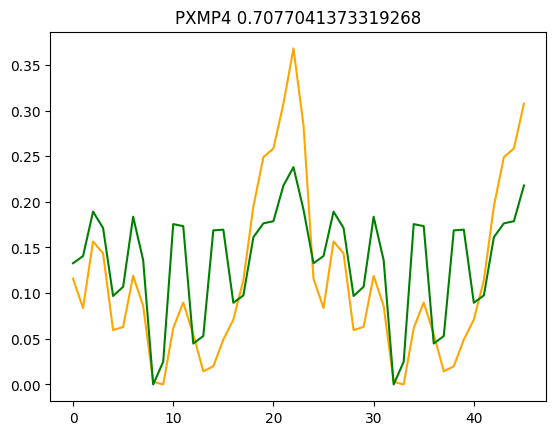

PXMP4   (CREBBP.&.POLR2A) 



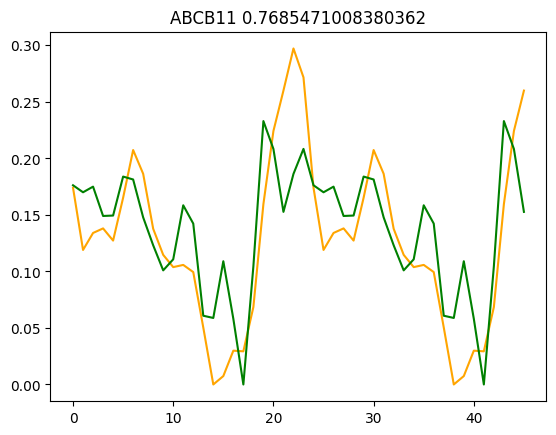

ABCB11   (PER1.&.CREBBP) 



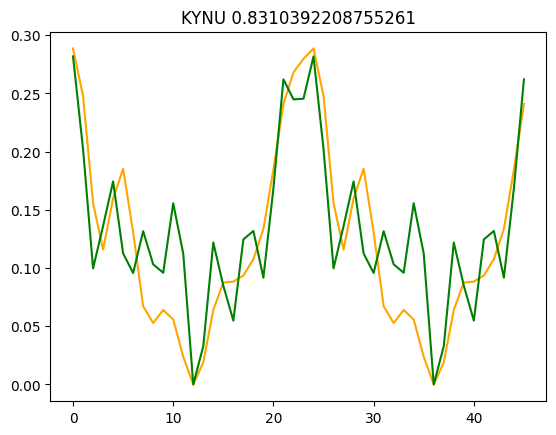

KYNU   (EP300.>.CREBBP) 



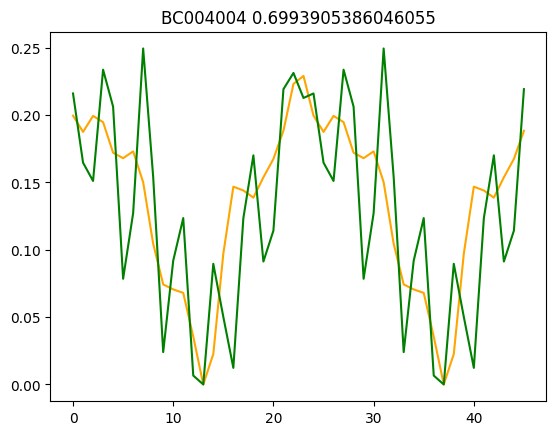

BC004004   (NPAS2.&.EP300) 



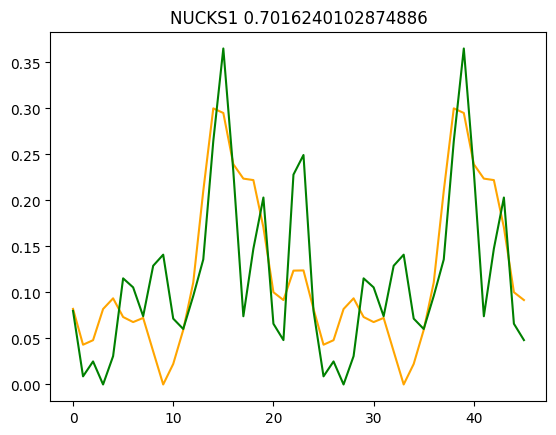

NUCKS1   (CRY2.&.PER1) 



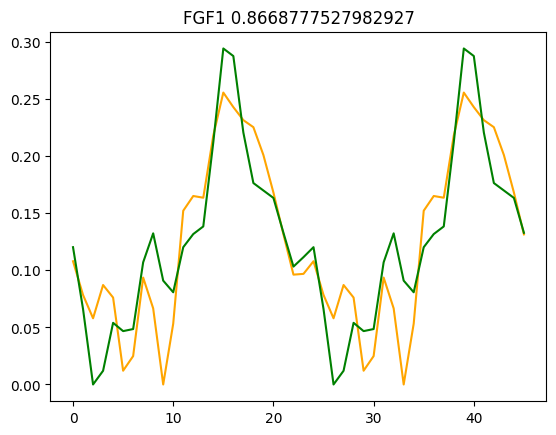

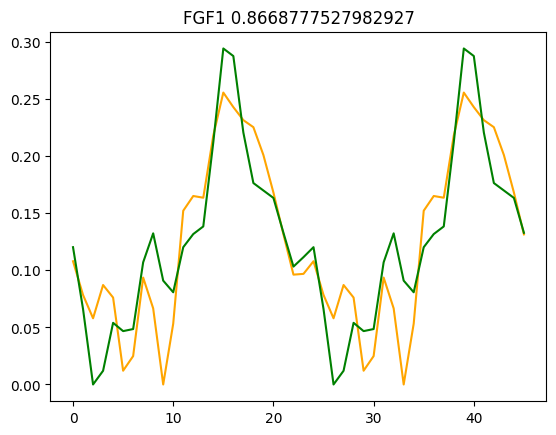

FGF1   (PER1.&.EP300).OR.(EP300.&.POLR2A) 



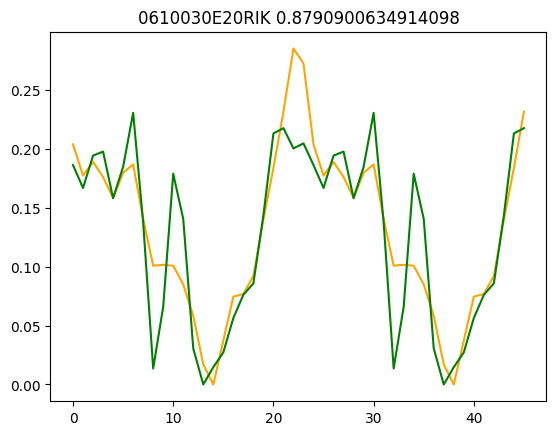

0610030E20RIK   (EP300.>.CREBBP) 



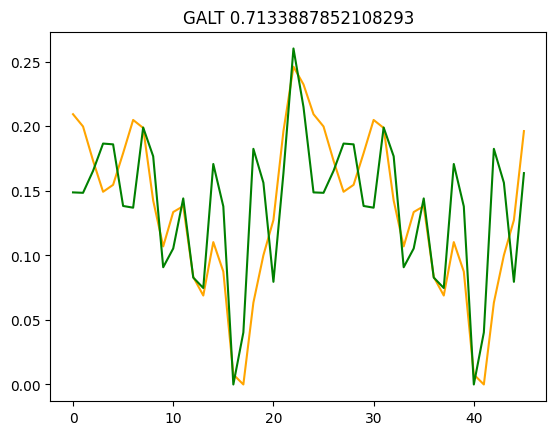

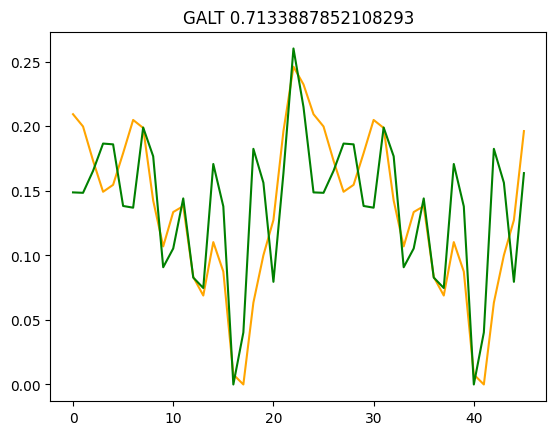

GALT   (CRY1.&.PER2).OR.(CREBBP.&.EP300) 



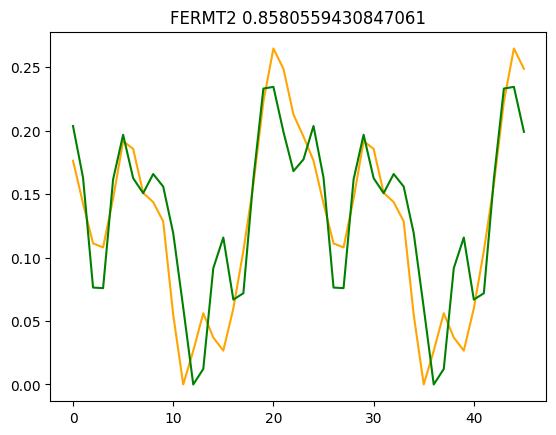

FERMT2   (EP300.>.NPAS2) 

Finish calculate logics WITH ARGS:  [0, 0, 0]
-0.7879009600671284


In [80]:
from scipy.optimize import brute

# ranges = (slice(0, 6, 1),) * 3
# result = brute(my_function, ranges, disp=True, finish=None)
# print(result)

print(my_function())
# from scipy.optimize import minimize

# # Определяем функцию, которую хотим минимизировать
# def equal_constraint(x):
#     for i in x:
#         if i != int(i):
#             return 1
#     return 0
# # Задаем начальное приближение для переменных и ограничения
# initial_guess = [3,3,3,3,3,
#                  3,3,3,3,3]
# bounds = ((0, 6), (0, 6), (0, 6), (0, 6), (0, 6),
#           (0, 6), (0, 6), (0, 6), (0, 6), (0, 6))  # Диапазон значений для каждой переменной: от -10 до 10
# constraints = ({'type':'eq','fun': lambda x : max([x[i]-int(x[i]) for i in range(len(x))])})
# result = minimize(my_function, initial_guess, bounds=bounds)

# # Выводим результаты
# print("Оптимальные аргументы:", result.x)
# print("Минимальное значение функции:", result.fun)

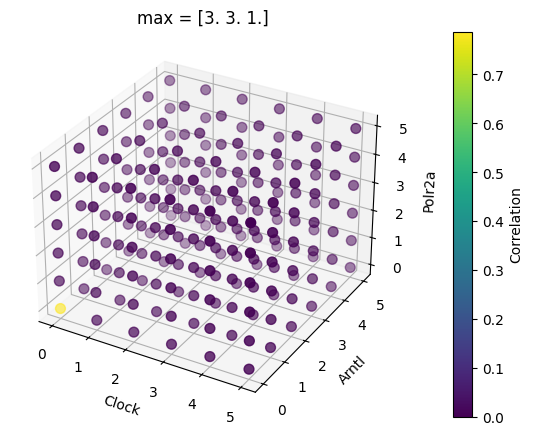

In [81]:
x, y, z = np.indices(array_3d.shape)
colors = array_3d

# Создание трехмерного графика
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111, projection='3d')
# Построение точек с цветами
sc = ax.scatter(x,y,z, c=colors, cmap='viridis', s=50)

ax.set_xlabel('Clock')
ax.set_ylabel('Arntl')
ax.set_zlabel('Polr2a')
# Добавление цветной шкалы
cbar = plt.colorbar(sc)
cbar.set_label('Correlation')
plt.title("max = [3. 3. 1.]")

plt.show()

[[[0]]]


/var/folders/5c/djcp36j97rldd49ns_5lr6700000gn/T/ipykernel_23092/630747431.py:1: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter


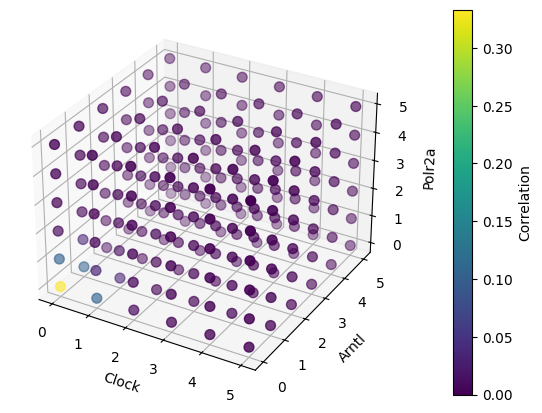

In [82]:
from scipy.ndimage.filters import gaussian_filter
blurred = gaussian_filter(array_3d, sigma=0.75)
colors = blurred
maxargs = np.argmax(blurred, keepdims=True)
print(maxargs)
# Создание трехмерного графика
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('Clock')
ax.set_ylabel('Arntl')
ax.set_zlabel('Polr2a')
# Построение точек с цветами
sc = ax.scatter(x,y,z, c=colors, cmap='viridis', s=50)

# Добавление цветной шкалы
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Correlation')

In [83]:
print(time_points)
weights = time_points[0] * replicates
weights = weights / np.sum(weights)

p1 = {}

for ind_KO in range(len(KO_sheets)):
    tmp_p1 = all_p0[ind_experiment][ind_KO]
    tmp_p1 = tmp_p1 * (tmp_p1 >= 0.5)

    p1[ind_KO] = tmp_p1 * weights[ind_experiment]
para = {}

{0: 49}


NameError: name 'replicates' is not defined

In [ ]:
logic_numberCode = {}
number_of_regulators = {}
for ind_KO in range(len(KO_sheets)):
    for TG_i in range(num_TG):
        cutting_thresh = 0.8
        logic_ind = np.where(p1[ind_KO][TG_i, :] > cutting_thresh)[0]

        if len(logic_ind) == 0:
            para[TG_i] = []
        else:
            total_logics = len(logic_ind)
            regulator_record = []

            for j in range(total_logics):
                logic_code = logic_gate[logic_ind[j]]

                if len(logic_code) == 1:
                    regulator_code = logic_code
                    ib1 = np.where(regulator_code == code)[0]
                    logic_numberCode[TG_i].append([ib1, 0, 0, p0[TG_i, logic_ind[j]]])
                    number_of_regulators[TG_i][j] = 1
                    ib2 = 0
                    regulator_record_i = [ib1, ib2]
                else:
                    regulator1_code = logic_code[0]
                    regulator2_code = logic_code[2]
                    operator_code = logic_code[1]

                    ib1 = np.where(regulator1_code == code)[0]
                    ib2 = np.where(regulator2_code == code)[0]
                    operator_number = operator_set.index(operator_code)

                    number_of_regulators[TG_i][j] = 2
                    logic_numberCode[TG_i].append([ib1, ib2, operator_number, p0[TG_i, logic_ind[j]]])

                    if operator_number == 2:
                        regulator_record_i = [ib1, 0]
                    elif operator_number == 1:
                        regulator_record_i = [ib1, ib2]
                    else:
                        regulator_record_i = [ib1, 0]
                regulator_record.extend(regulator_record_i)
    save_logic_file = path_of_output + name_of_output

for i in range(len(all_logic_string)):
    print(TGs[i], " ", all_logic_string[i], '\n')

FGB   ['(CLOCK.&.ARNTL)'] 

DDX58   ['(CLOCK.>.ARNTL)', '.OR.', '(CLOCK.|.PER1)'] 

CSRP3   ['(CLOCK.>.CREBBP)'] 

NARS2   ['(ARNTL.&.CRY2)'] 

PPA1   ['(CRY1.&.POLR2A)'] 

HACL1   ['(PER2)', '.OR.', '(CRY1.&.POLR2A)'] 

BHMT2   ['(CRY1.>.NPAS2)'] 

APOC3   ['(CRY1.|.POLR2A)', '.OR.', '(POLR2A.>.PER2)'] 

FAHD1   ['(CRY1.>.POLR2A)'] 

ASB13   ['(ARNTL.&.CRY1)'] 

ABHD14A   ['(ARNTL.&.CRY1)', '.OR.', '(ARNTL.&.PER2)'] 

SUMO3   ['(CLOCK.&.CRY1)', '.OR.', '(ARNTL.&.CRY1)'] 

MYO1B   ['(PER1.&.POLR2A)'] 

ALKBH7   ['(CLOCK.&.CRY1)'] 

OXNAD1   ['(CRY1.>.PER2)'] 

ACSL5   ['(ARNTL.&.CRY1)', '.OR.', '(ARNTL.&.CREBBP)'] 

PSMD1   ['(CLOCK.|.PER1)', '.OR.', '(PER1.>.POLR2A)'] 

WDR91   ['(CLOCK.>.CRY1)'] 

GLO1   ['(ARNTL)'] 

PSMC2   ['(CRY1)'] 

TSPAN33   ['(CRY1)'] 

TBCB   ['(CREBBP.>.CRY1)'] 

RAPGEF6   ['(CREBBP.&.POLR2A)'] 

MCFD2   ['(CRY1.>.ARNTL)'] 

MRPS27   ['(CRY1.>.PER2)'] 

LRRC3   ['(PER2.>.CRY1)'] 

MRPL34   ['(CRY1.&.PER2)'] 

FKBP4   ['(CRY1.>.PER2)'] 

NUP62   ['(CRY1.>.PE